# TODO: Angle aerofoils 

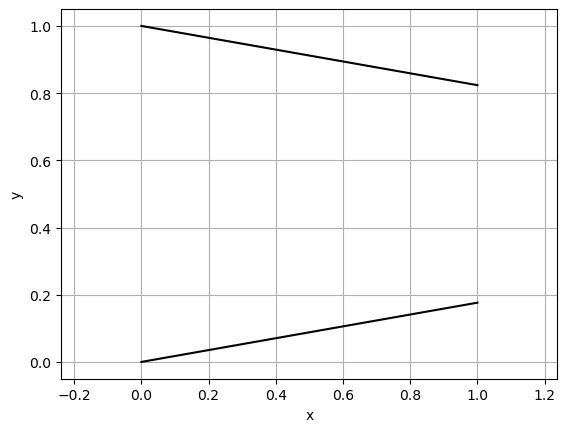

In [23]:
from aerofoil import *
from matplotlib import pyplot as plt


foil_width = 0.2
turbine_width = 0.8 + foil_width
turbine_length = 1
t_c = 0.2
alphas = [10,-10]

# x,y = custom_foil(foil_width, t_c,alpha=alphas[0], side='left')
# x2,y2 = custom_foil(foil_width, t_c,alpha=alphas[1], side='right')
# y2 = y2 + turbine_width

# Create a NACA 0012 aerofoil
# x,y = naca_foil(foil_width, alpha=alphas[0])
# x2,y2 = naca_foil(foil_width, alpha=alphas[1])
# y2 = y2 + turbine_width
# 
x, y = nozzle_foil(alpha=alphas[0])
x2, y2 = nozzle_foil(alpha=alphas[1])

# x,y = naca_one_side(foil_width,side='left', alpha=alphas[0])
# x2,y2 = naca_one_side(foil_width,side='right', alpha = alphas[1])
# y2 = y2 + turbine_width

# scale the aerofoil length
x = x * turbine_length
x2 = x2 * turbine_length

# Plot the aerofoil
plt.plot(x,y,'k-')
plt.plot(x2,y2 + turbine_width,'k-')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()



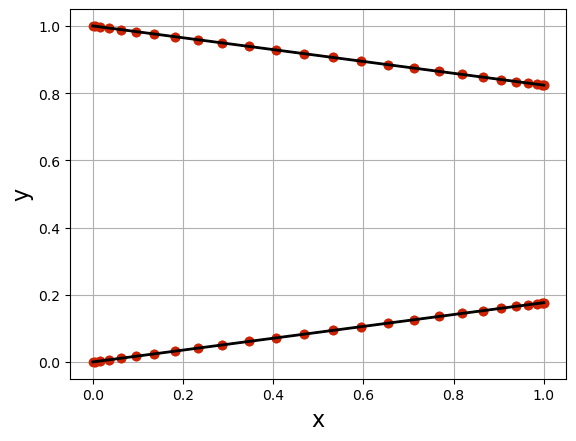

In [24]:
import numpy as np

plt.figure()
aerofoils = np.empty(2, dtype=object)
# aerofoils = np.empty(1, dtype=object)
coords = [[x,y],[x2,y2]]
# coords = [[x,y]]
# discretise the aerofoil into panels
for i,aerofoil in enumerate(coords):
    aerofoils[i] = define_panels(aerofoil[0],aerofoil[1],N=50)

# now move the aerofoils to the correct position
for panel in aerofoils[1]:
    panel.ya = panel.ya + turbine_width
    panel.yb = panel.yb + turbine_width
    panel.yc = panel.yc + turbine_width
y2 = y2 + turbine_width


# plot the panels
for i,aerofoil in enumerate(aerofoils):
    plt.plot(np.append([panel.xa for panel in aerofoil], aerofoil[0].xa),
            np.append([panel.ya for panel in aerofoil], aerofoil[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
    



plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.plot(x2, y2, color='k', linestyle='-', linewidth=2)




In [25]:
# define the freestream conditions
u_inf = 1
alpha = 0
freestream_1 = Freestream(u_inf, alpha)
freestream_2 = Freestream(u_inf, -alpha)
freestreams = [freestream_1, freestream_2]

In [26]:
for i,p in enumerate(aerofoils):  
    A = A_mat(p)
    b = b_vec(p, freestreams[i])

    # solve the linear system
    variables = np.linalg.solve(A, b)

    # store the source strength on each panel
    for ii, panel in enumerate(p):
        panel.sigma = variables[ii]

    # get tangential velocity at each panel center-point
    tan_vel(p, freestreams[i])
    # get pressure coefficient at each panel center-point
    cp(p, freestreams[i])

Velocity at x_point = 0.5, y_point = 0.5 is u = 0.9988923287181614 and v = -0.0027375214393594435


Text(0.14999999999999997, 0.5, '1.00')

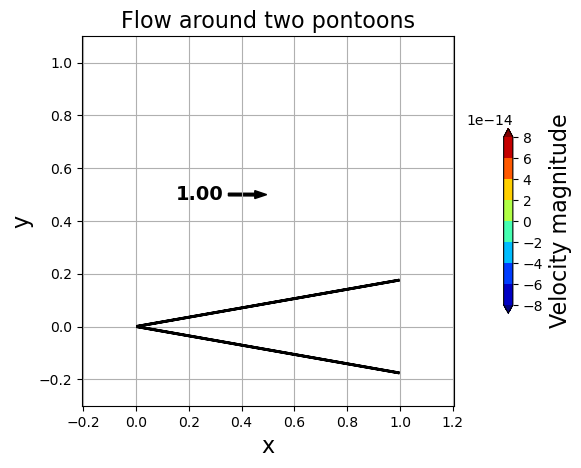

In [30]:
# define velocity field
nx, ny = 20, 20
x_start, x_end = -0.1, turbine_length + 0.1
y_start, y_end = -0.1 - foil_width, turbine_width + 0.1
x_ = np.linspace(x_start, x_end, nx)
y_ = np.linspace(y_start, y_end, ny)
X, Y = np.meshgrid(x_, y_)

plt.figure()
plt.axis('equal')
# compute the velocity field on the mesh grid
u_tot = np.zeros((ny, nx))
v_tot = np.zeros((ny, nx))
for i,panels in enumerate(aerofoils):
    u, v = vel_field(panels, freestreams[i], X, Y)
    u_tot += u
    v_tot += v

# normalize the velocity field
u_tot /= 2 * u_inf
v_tot /= 2 * u_inf

# # plot the velocity field  
# plt.streamplot(X, Y, u_tot, v_tot, density=2, linewidth=1, arrowsize=1, arrowstyle='->')

for panels in aerofoils:
    plt.fill([panel.xc for panel in panels],
        [panel.yc for panel in panels],
        color='k', linestyle='solid', linewidth=2, zorder=2)
    
# add contours of velocity
plt.contourf(X, Y, np.sqrt(u_tot**2 + v_tot**2), extend='both', cmap='jet', levels=10)
cbar = plt.colorbar(orientation='vertical', shrink=0.5, pad=0.1)
cbar.set_label('Velocity magnitude', fontsize=16)

plt.grid()
plt.title('Flow around two pontoons', fontsize=16)
plt.xlim(x_start, x_end)
plt.ylim(y_start, y_end)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)

# calculate velocity at x = 0.5, y = width/2
x_point = 0.35
y_point = turbine_width/2
u,v = vel_field(panels, freestreams[0], x_point, y_point)
print('Velocity at x_point = 0.5, y_point = 0.5 is u = {} and v = {}'.format(u,v))

# put an arrow there
plt.arrow(x_point, y_point, u/10, v/10, width=0.01, color='k')

# find the net velocity at this point
vel = np.sqrt(u**2 + v**2)
plt.text(x_point-0.2, y_point, '%.2f' %vel, fontsize=14, fontweight='bold', va='center')



In [28]:
from power_calcs import *

# calculate the power output of the turbine at this point
rho = 1000
efficiency = 0.3 # Efficiency to be confirmed 
area = 0.8

print("Power output with pontoons....\n")
power,_,_,_,_ = power_calc(efficiency=efficiency, A=area, V=vel)

print("Power output without pontoons....\n")
power,_,_,_,_ = power_calc(efficiency=efficiency, A=area, V=u_inf)


Power output with pontoons....


-------------------------------------------


---------Calculating Power---------
Power =  239.2060546098255

-------------------------------------------
All variables calculated.

Power =  239.2060546098255

efficiency =  0.3

Area =  0.8

Velocity =  0.9988960798779932

-------------------------------------------
Power output without pontoons....


-------------------------------------------


---------Calculating Power---------
Power =  240.0

-------------------------------------------
All variables calculated.

Power =  240.0

efficiency =  0.3

Area =  0.8

Velocity =  1

-------------------------------------------
